In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import xcoll.geometry.trajectories as tr
import xcoll.geometry.segments as seg
# %matplotlib ipympl
%matplotlib tk

# s0 = 0.1
# x0 = 1
# xp = np.tan(np.deg2rad(30.))

# ran_1 = np.random.normal()
# ran_2 = np.random.normal()

# drift = tr.DriftTrajectory(s0=s0, x0=x0, xp=xp)
# circ = tr.CircularTrajectory(s0=s0, x0=x0, sR=-1, xR=2)
# mcs = tr.MultipleCoulombTrajectory(s0=s0, x0=x0, xp=xp, pc=1e9, beta=1/np.sqrt(1+1.), q=1,X0=0.1, ran_1=ran_1, ran_2=ran_2)

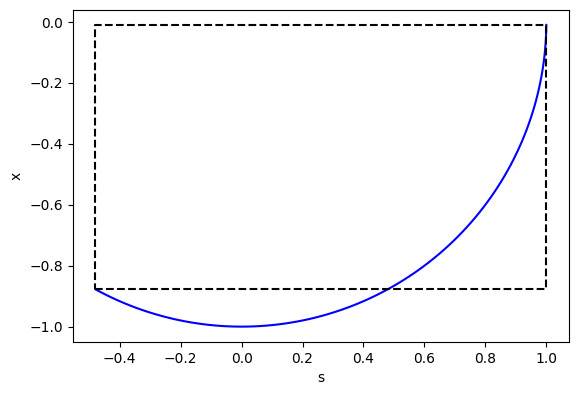

In [6]:
fig, _ =  tr.CircularTrajectory(s0=0, x0=-1, sR=0, xR=0).plot(l1=-0.5, l2=np.pi/2-0.01)


In [ ]:
kwargs = {
    's1': [-3, 3, 0],
    'x1': [-3, 3, 0],
    's2': [-3, 3, 1],
    'x2': [-3, 3, 1],
}

seg.LineSegment._inspect(**kwargs)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [ ]:
kwargs = {
    'R': [0.1, 3, 1.2],
    'sR': [-3, 3, 0.2],
    'xR': [-3, 3, -0.3],
    'theta1': [-2*np.pi, 2*np.pi, -np.pi/3],
    'theta2': [-2*np.pi, 2*np.pi, np.pi/3],
}

seg.CircularSegment._inspect(**kwargs)

Compiling ContextCpu kernels...


Done compiling ContextCpu kernels.


In [3]:
circ2

<CircularSegment((0.94, 0.342)-b-(20°:50°:1.0)-b-(0.643, 0.766)) at 0x7f5d70794d50>

In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext wurlitzer
%matplotlib ipympl

import numpy as np
import xobjects as xo

import xcoll as xc
from xcoll.geometry.segments import get_max_crossings
from xcoll.geometry.trajectories import DriftTrajectory

import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def check_drift(shape, plot_object=False, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5)):
    to_remove = []
    s_val = np.linspace(*xlim, 200)
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    if plot_object:
        shape.plot(axes=ax)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    n_hit = np.zeros(1, dtype=np.int8)
    s = np.zeros(get_max_crossings(shape, DriftTrajectory), dtype=np.float64)
    # s = np.zeros(8, dtype=np.float64)

    def update_plot(s0, x0, part_theta):
        # Clean the previous trajectory and points
        while to_remove:
            last_point = to_remove.pop()  # Get the last added point
            last_point.remove()
        m = np.tan(np.radians(part_theta))
        # Draw drift trajectory and point
        spread = 10 # degrees
        line, = ax.plot(s_val, m*(s_val - s0) + x0, c='k')
        to_remove.append(line)
        scatter = ax.scatter(s0, x0, c='r', s=20)
        to_remove.append(scatter)
        m1 = np.tan(np.radians(part_theta+spread))
        m2 = np.tan(np.radians(part_theta-spread))
        line = ax.fill_between(s_val, m1*(s_val - s0) + x0, m2*(s_val - s0) + x0, alpha=0.2)
        to_remove.append(line)
        # Create hits for different slopes (small cone around the trajectory)
        hits_s = []
        hits_x = []
        for sp in np.linspace(-spread, spread, 100):
            n_hit[0] = 0
            m = np.tan(np.radians(part_theta + sp))
            if isinstance(shape, xc.Shape2DV):
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m, y0=0, ym=0)
            else:
                shape.crossing_drift(n_hit=n_hit, s=s, s0=s0, x0=x0, xm=m)
            hits_s += list(s[:n_hit[0]])
            hits_x += list(x0 + m*(s[:n_hit[0]] - s0))
        # for i in range(n_hit[0]):
        scatter = ax.scatter(hits_s, hits_x, c='g', s=5)
        # to_remove.append(scatter)
        fig.canvas.draw()  # Redraw the canvas to show the new point


    def onclick(event):
        s0, x0 = event.xdata, event.ydata
        if s0 is not None and x0 is not None:  # Ensure the click is inside the plot
            update_plot(s0, x0, part_theta_slider.value)


    fig.canvas.mpl_connect('button_press_event', onclick)
    part_theta_slider = widgets.IntSlider(min=-89, max=89, step=1, value=0)

    @interact(part_theta=part_theta_slider)
    def check_linesegments(part_theta):
        if to_remove:
            scatter = to_remove[1]  # The second point is the clicked scatter point
            s0, x0 = scatter.get_offsets()[0, 0], scatter.get_offsets()[0, 1]

            # Update the plot with the new slope based on the slider
            update_plot(s0, x0, part_theta)

In [3]:
shape1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])
shape2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
shape3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4),
                      xc.HalfOpenLineSegment(s=1.8, x=-0.5, t=5*np.pi/8),
                      xc.CircularSegment(R=0.3, s=1.8-0.3*np.cos(np.pi/8), x=-0.5-0.3*np.sin(np.pi/8), t1=-7*np.pi/8, t2=np.pi/8),
                      xc.HalfOpenLineSegment(s=1.8-0.6*np.cos(np.pi/8), x=-0.5-0.6*np.sin(np.pi/8), t=5*np.pi/8)],
                     vlimit=[-0.1, 0.1])
shape4 = xc.Shape2DV([xc.CircularSegment(R=1, s=0, x=0, t1=0, t2=2*np.pi/3),
                      xc.CircularSegment(R=1, s=0, x=0, t1=2*np.pi/3, t2=4*np.pi/3),
                      xc.CircularSegment(R=1, s=0, x=0, t1=4*np.pi/3, t2=2*np.pi)],
                     vlimit=[-0.1, 0.1])
R1 = 0.5
R2 = 2
t = np.arcsin(R1/R2)
shape5 = xc.Shape2D([xc.CircularSegment(R=R1, s=0, x=0, t1=np.pi/2, t2=-np.pi/2),
                     xc.CircularSegment(R=R2, s=-R2*np.cos(t), x=0, t1=-t, t2=t)])
shape6 = xc.Shape2D([xc.HalfOpenLineSegment(s=0, x=0, t=np.pi/4),
                     xc.HalfOpenLineSegment(s=0, x=0, t=-np.pi/4)])

In [6]:
#This is meant to fail

xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
            xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)]).get_vertices()

In [ ]:
fig, _ = shape1.plot3d(); fig.show()
fig, _ = shape2.plot3d(); fig.show()
fig, _ = shape3.plot3d(); fig.show()
fig, _ = shape4.plot3d(); fig.show()
fig, _ = shape5.plot3d(); fig.show()
fig, _ = shape6.plot3d(); fig.show()

In [ ]:
shape_1 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1), xc.LineSegment(s1=0.2, x1=1, s2=1, x2=1),
                     xc.LineSegment(s1=1, x1=1, s2=0.8, x2=0), xc.LineSegment(s1=0.8, x1=0, s2=0, x2=0)])

check_drift(shape_1, plot_object=False)

In [ ]:
shape_2 = xc.Shape2D([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                     xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                     xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                     xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                     xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                     xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                     xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)])
check_drift(shape_2, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)

In [ ]:
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=np.pi/2,  t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=3*np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=2*np.pi)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=0,        t2=-np.pi/2)
# seg = xc.CircularSegment(R=1, s=0., x=0., t1=-np.pi/2, t2=0)
seg = xc.CircularSegment(R=1, s=0., x=0., t1=3*np.pi/2,t2=0)

check_drift(xc.Shape2D([seg]), plot_object=True, xlim=(-1.5, 1.5), ylim=(-1.5, 1.5))

In [ ]:
shape_3 = xc.Shape2DV([xc.LineSegment(s1=0, x1=0, s2=0.2, x2=1),
                      xc.BezierSegment(s1=0.2, x1=1, s2=1+0.5*np.cos(3*np.pi/4), x2=0.5+0.5*np.sin(3*np.pi/4), cs1=0.5, cx1=2.5, cs2=1+0.5*np.cos(3*np.pi/4)-0.6, cx2=0.5+0.5*np.sin(3*np.pi/4)-0.6),
                      xc.CircularSegment(R=0.5, s=1, x=0.5, t1=-np.pi/2, t2=3*np.pi/4),
                      xc.LineSegment(s1=1, x1=0, s2=0, x2=0),
                      xc.HalfOpenLineSegment(s=2, x=1, t=np.pi/4),
                      xc.LineSegment(s1=2, x1=1, s2=3, x2=0),
                      xc.HalfOpenLineSegment(s=3, x=0, t=np.pi/4)],
                    vlimit=[-0.1, 0.1])
check_drift(shape_3, xlim=(-0.5, 4), ylim=(-0.5,2), plot_object=True)